In [1]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, config, stats
from cosmikyu import utils as cutils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
def data_path(x):
    return os.path.join(sehgal_dir, x)
SDS_validation = datasets.SehgalDataSet(sehgal_dir, data_type="validation141020", transforms=[], dummy_label=False)
data = np.zeros((5, 128, 128*len(SDS_validation)))
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]

for i in range(len(SDS_validation)):
    sidx = 128*i
    data[...,sidx: sidx+128] = SDS_validation[i]
    
def sehgal_path(x):
    return os.path.join(sehgal_dir, x)

#enplot.pshow(data[:,:128,:128])

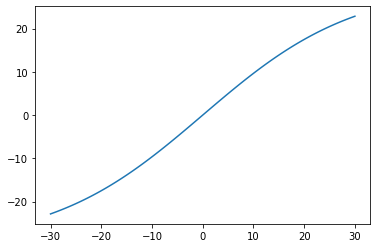

In [22]:
x = np.linspace(-30,30,100)
a = 30
b = 1/30
y = a*np.tanh(x*b)

plt.plot(x, y)

kappa


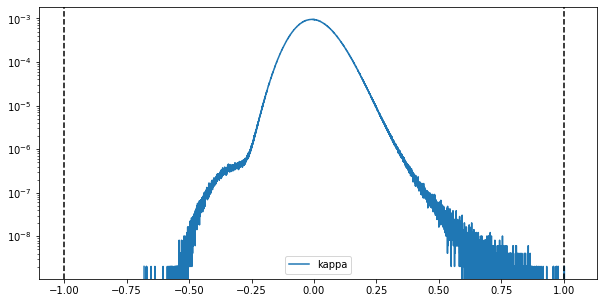

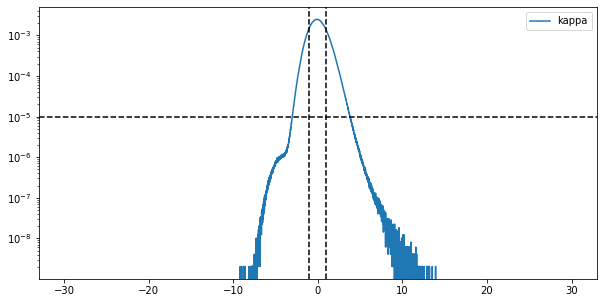

ksz


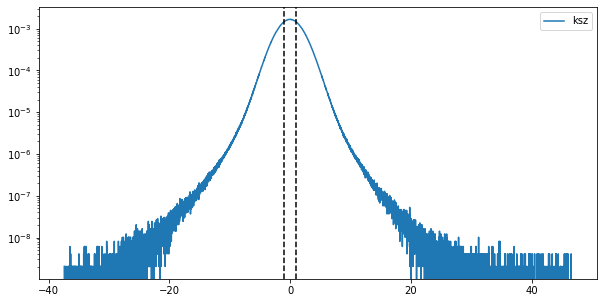

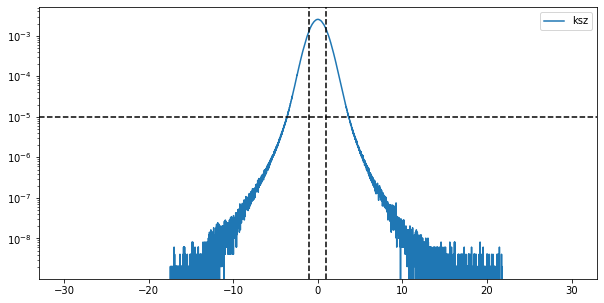

tsz


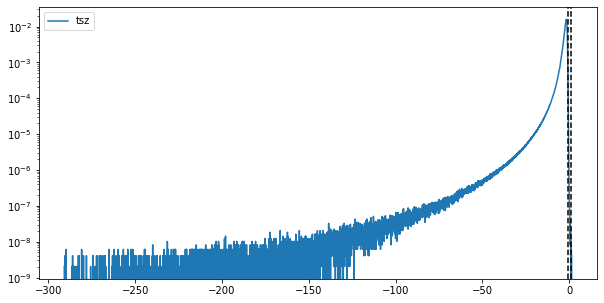

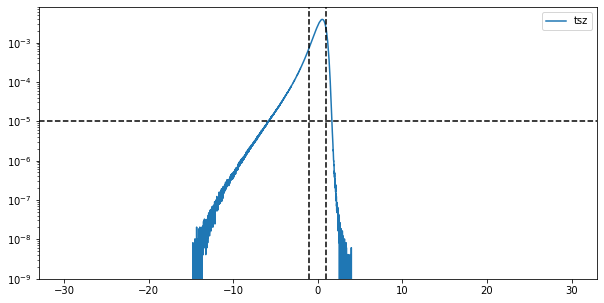

ir_pts


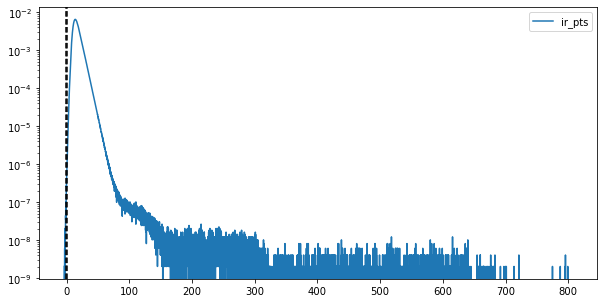

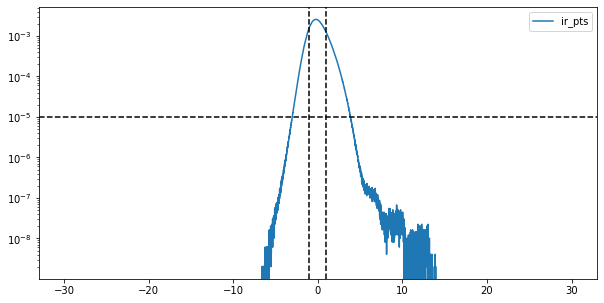

rad_pts


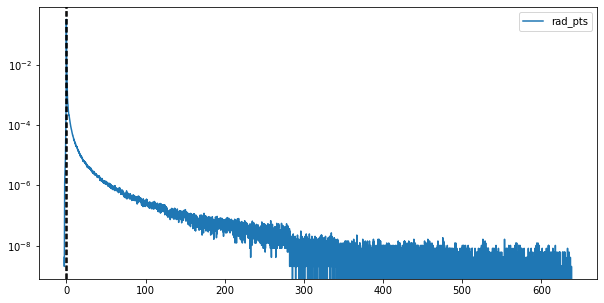

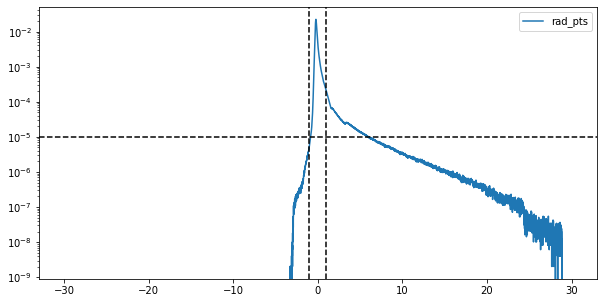

In [18]:
zfact = 1
def log_normalize(data):
    emap = data["emap"] 
    info = data["info"]
    std = np.std(emap)
    info["lognorm_std"] = std.copy()
    
    loc = np.where(emap>=0)
    emap[loc] = np.log(emap[loc]/std+1)
    loc = np.where(emap<0)
    emap[loc] = -1*np.log(np.abs(emap[loc]/std)+1)
    data["emap"] = emap
    return data


def z_normalize(data, zfact = zfact):
    emap = data["emap"] 
    info = data["info"]
    mean, std = emap.mean(), emap.std()
    info["znorm_mean"] = mean
    info["znorm_std"] = std
    info["znorm_zfact"] = zfact
    data["emap"] = (emap-mean)/(std*zfact)
    return data


def shrink(data, factor = 1):
    emap = data["emap"] 
    info = data["info"]
    info["shrink_fact"] = factor
    data["emap"]  = emap/factor
    return data

def minmax(data):
    emap = data["emap"] 
    info = data["info"]
    maxval, minval = emap.max(),emap.min()
    #maxval = np.max(np.abs([maxval, minval]))
    info["minmax_min"] = minval
    info["minmax_max"] = maxval
    valrange = (maxval-minval)
    midval = (maxval+minval)/2
    info["minmax_mean"] = midval
    data["emap"] = (emap-midval)/valrange*2
    return data

'''
def shrink(data):
    emap = data["emap"] 
    info = data["info"]  
    mean = emap.mean()
    info["minmax_mean"] = mean
    maxval, minval = emap.max(),emap.min()
    
    
    
    maxval = np.max(np.abs([maxval-mean, minval-mean]))
    minval = -1*maxval
    valrange = (maxval-minval)
    midval = mean#(maxval+minval)/2
    info["minmax_min"] = minval
    info["minmax_max"] = maxval    
    data["emap"] = (emap-midval)/valrange*2
    return data
   
    
def shrinkv2(data):
    emap = data["emap"] 
    info = data["info"]  
    mean = emap.mean()
    info["shrink_mean"] = mean
    emap = emap - mean 
    maxval, minval = emap.max(),emap.min()
    loc = np.where(emap>0)
    maxpos = emap[loc].max()
    #emap[loc] /= maxpos
    loc = np.where(emap<0)
    maxmin = emap[loc].min()

    #emap[loc] /= -1*maxmin
    
    info["shrink_min"] = minval
    info["shrink_max"] = maxval  
    
    
    
    #maxval = np.max(np.abs([maxval-mean, minval-mean]))
    #minval = -1*maxval
    #valrange = (maxval-minval)
    midval = mean#(maxval+minval)/2
  
    data["emap"] = emap
    return data
    
'''

freq_idx = 148
ns = {"kappa": lambda x: shrink(z_normalize(x)),
      "ksz": lambda x: shrink(z_normalize(x)),
      "ir_pts": lambda x: shrink(z_normalize(log_normalize(x))),
      "rad_pts": lambda x: shrink(z_normalize(log_normalize(x))),
      "tsz": lambda x: shrink(z_normalize(log_normalize(x))),
     }
nbins = 10000

norm_info_validation = {}
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]


for i, compt_idx in enumerate(compts):
    print(compt_idx)
    storage = {}
    storage["emap"]  = data[i].copy() 
    storage["info"]  = {}
    minval, maxval = storage["emap"].min(), storage["emap"].max()
    
    MB = stats.FastBINNER(minval, maxval, nbins)
    bin_center, hist = MB.bin(data[i].copy())
    fig = plt.figure(figsize=(10, 5))
    plt.plot(bin_center, hist/np.sum(hist), label=compt_idx)
    plt.legend()
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.yscale("log")
    plt.show()
    
    
    storage = ns[compt_idx](storage)
    norm_info_validation[compt_idx] = storage["info"]
    
    MB = stats.FastBINNER(-30, 30, nbins)
    bin_center, hist = MB.bin(storage["emap"])
    #hist, bins = np.histogram(data["emap"], bins=1024)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(bin_center, hist/np.sum(hist), label=compt_idx)
    plt.axvline(x=1, ls="--", color="k")
    plt.axvline(x=-1, ls="--", color="k")
    plt.axhline(y=1e-5, ls="--", color="k")
    plt.legend()
    #plt.xlim(-12,12)
    plt.yscale("log")
    #plt.xscale("symlog")
    plt.show()


In [19]:
for idx in norm_info_validation.keys():  
    print(idx, norm_info_validation[idx])

np.savez(data_path("201020_logzshrink_normalization_info_validation.npz"), **norm_info_validation)


kappa {'znorm_mean': -2.6458898250364806e-05, 'znorm_std': 0.07407179512283714, 'znorm_zfact': 1, 'shrink_fact': 1}
ksz {'znorm_mean': -0.00406070836384978, 'znorm_std': 2.1445520917184044, 'znorm_zfact': 1, 'shrink_fact': 1}
tsz {'lognorm_std': 2.567613946408688, 'znorm_mean': -0.6697793761660281, 'znorm_std': 0.27506589295912703, 'znorm_zfact': 1, 'shrink_fact': 1}
ir_pts {'lognorm_std': 6.573228652867444, 'znorm_mean': 1.2275252038993216, 'znorm_std': 0.2578374089312665, 'znorm_zfact': 1, 'shrink_fact': 1}
rad_pts {'lognorm_std': 3.6703679499683948, 'znorm_mean': 0.04452964517724535, 'znorm_std': 0.17718972897499652, 'znorm_zfact': 1, 'shrink_fact': 1}


7.808393803213246e-16
5.040697656809075e-16
7.435717399468012e-16
5.897191134844301e-16
1.0396110122390389e-10
0
-13.9629795644687 28.814857597313356 -0.0020172856444028806
start binning
0
1
2
3
4


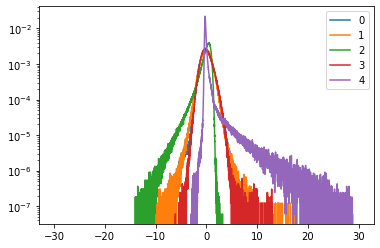

In [24]:
## normalizationtest

norm_info_file = data_path("201020_logzshrink_normalization_info_validation.npz")
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
#SDN = transforms.SehgalDataNormalizerScaledLogMinMax(norm_info_file)
#SUN = transforms.SehgalDataUnnormalizerScaledLogMinMax(norm_info_file)
SDS_validation = datasets.SehgalDataSet(sehgal_dir, data_type="validation141020", dummy_label=False)

stamp = SDS_validation[0].copy()
stamp_norm = SDN(stamp.copy())
stamp_unnorm = SUN(stamp_norm.copy())

for i in range(5):
    maxval = np.max(np.abs((stamp[i]-stamp_unnorm[i])/(stamp_unnorm[i])))
    print(maxval)


nsample = 1000 #len(SDS_validation)
data = np.zeros((5, 128, 128*nsample))
nbins = 10000

for i in range(nsample):
    if i % 5000 == 0: print(i)
    sidx = 128*i
    data[...,sidx: sidx+128] = SDN(SDS_validation[i])
print(data.min(), data.max(), data.mean())
print("start binning")
MB = stats.FastMultBinner((-30,30), nbins, data.shape[0])
MB.bin(data)

ret = MB.get_info()
out = {}
for key in range(5):
    print(key)
    plt.plot(ret[key]["bin_centers"], ret[key]["hist"]/np.sum(ret[key]["hist"]), label=key)
    plt.yscale("log")
plt.legend()
plt.show()
    


In [7]:
#norm_info_file = data_path("201020_logzshrink_normalization_info_validation.npz")
#SDN = transforms.SehgalDataNormalizerScaledLogMinMax(norm_info_file)
norm_info_file = data_path("201020_logzshrink_normalization_info_validation.npz")
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SDS_validation = datasets.SehgalDataSet(sehgal_dir, data_type="validation141020", transforms=[SDN], dummy_label=False)

nsample = len(SDS_validation)
data = np.zeros((5, 128, 128*nsample))
nbins = 10000

for i in range(nsample):
    if i % 5000 == 0: print(i)
    sidx = 128*i
    data[...,sidx: sidx+128] = SDS_validation[i]
print(data.min(), data.max(), data.mean())
print("start binning")
MB = stats.FastMultBinner((-30,30), nbins, data.shape[0])
MB.bin(data)
    
ret = MB.get_info()
out = {}
for key in range(5):
    print(key)
    out[SDN.channel_idxes[key]] = ret[key].copy()
ret = out
np.savez(sehgal_path("201020_normalized_histogram_validation_{}.npz".format(nbins)), **out)

0
5000
10000
15000
20000
25000
-17.44354915394075 28.892431024645127 7.546142604016038e-15
start binning
0
1
2
3
4


In [8]:
#norm_info_file = data_path("191020_logminmax_normalization_info_validation.npz")
#SDN = transforms.SehgalDataNormalizerScaledLogMinMax(norm_info_file)
norm_info_file = data_path("201020_logzshrink_normalization_info_validation.npz")
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="test141020", transforms=[SDN], dummy_label=False)

nsample = len(SDS_test)
data = np.zeros((5, 128, 128*nsample))
SDS_test
nbins = 10000
for i in range(nsample):
    if i % 5000 == 0: print(i)
    sidx = 128*i
    data[...,sidx: sidx+128] = SDS_test[i]
print(data.min(), data.max(), data.mean())
print("start binning")
MB = stats.FastMultBinner((-30,30), nbins, data.shape[0])
MB.bin(data)
    
ret = MB.get_info()
out = {}
for key in range(5):
    print(key)
    out[SDN.channel_idxes[key]] = ret[key].copy()
ret = out
np.savez(sehgal_path("201020_normalized_histogram_test_{}.npz".format(nbins)), **out)

0
5000
10000
15000
20000
25000
-17.451651082817836 28.89122994166014 -0.0005343926445110802
start binning
0
1
2
3
4


In [9]:
norm_info_file = data_path("201020_logzshrink_normalization_info_validation.npz")
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
#norm_info_file = data_path("191020_logminmax_normalization_info_validation.npz")
#SDN = transforms.SehgalDataNormalizerScaledLogMinMax(norm_info_file)
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="test141020", transforms=[], dummy_label=False)

nsample = len(SDS_test)
data = np.zeros((5, 128, 128*nsample))

nbins = 10000
for i in range(nsample):
    if i % 5000 == 0: print(i)
    sidx = 128*i
    data[...,sidx: sidx+128] = SDS_test[i]
print(data.min(), data.max(), data.mean())
print("start binning")
MB = stats.FastMultBinner((-30,30), nbins, data.shape[0])
MB.bin(data)
    
ret = MB.get_info()
out = {}
for key in range(5):
    print(key)
    out[SDN.channel_idxes[key]] = ret[key].copy()
ret = out
np.savez(sehgal_path("201020_raw_histogram_test_{}.npz".format(nbins)), **out)

0
5000
10000
15000
20000
25000
-290.7731033193691 803.6106114930507 2.849090983757404
start binning
0
1
2
3
4


In [ ]:
#norm_info_file = data_path("191020_logminmax_normalization_info_validation.npz")
#SDN = transforms.SehgalDataNormalizerScaledLogMinMax(norm_info_file)
norm_info_file = data_path("201020_logzshrink_normalization_info_validation.npz")
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SDS_train = datasets.SehgalDataSet(sehgal_dir, data_type="train141020", transforms=[SDN], dummy_label=False)

nsample = len(SDS_train)
data = np.zeros((5, 128, 128*nsample))

nbins = 10000
for i in range(nsample):
    if i % 5000 == 0: print(i)
    sidx = 128*i
    data[...,sidx: sidx+128] = SDS_train[i]
print(data.min(), data.max(), data.mean())
print("start binning")
MB = stats.FastMultBinner((-30,30), nbins, data.shape[0])
MB.bin(data)
    
ret = MB.get_info()
out = {}
for key in range(5):
    print(key)
    out[SDN.channel_idxes[key]] = ret[key].copy()
ret = out
np.savez(sehgal_path("201020_normalized_histogram_train_{}.npz".format(nbins)), **out)